### Imputation using Kalman Filter

In [1]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import LocalOutlierFactor
import missingno as msno
import matplotlib.pyplot as plt





In [2]:
df = pd.read_csv("final_data.csv")

In [3]:
print(df.dtypes)

timestamp                        float64
Acceleration x (m/s^2)           float64
Acceleration y (m/s^2)           float64
Acceleration z (m/s^2)           float64
amplitude                        float64
frequency                        float64
Gyroscope x (rad/s)              float64
Gyroscope y (rad/s)              float64
Gyroscope z (rad/s)              float64
Illuminance (lx)                 float64
Linear Acceleration x (m/s^2)    float64
Linear Acceleration y (m/s^2)    float64
Linear Acceleration z (m/s^2)    float64
Latitude (°)                     float64
Longitude (°)                    float64
Height (m)                       float64
Velocity (m/s)                   float64
Direction (°)                    float64
Horizontal Accuracy (m)          float64
Vertical Accuracy (m)            float64
Magnetic field x (µT)            float64
Magnetic field y (µT)            float64
Magnetic field z (µT)            float64
Pressure (hPa)                   float64
Distance (cm)   

In [ ]:
msno.matrix(df)
plt.show()

In [ ]:
def one_d_kalman_filter(df):
    """basic 1d kalman filterfunction based on the function provided by the professor (sigh)"""
    for i,column in enumerate(df.columns):
        print(f"{i} column out of {len(df.columns)}")
        if not is_numeric_dtype(df[column]):
            continue
        else:
            kf =  KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]]) #transition and observation matrices for computations
            masked_values = np.ma.masked_invalid(df[column].values.astype(np.float32))

            kf_params = kf.em(masked_values,n_iter=3) #optimizes Q and R (the noise estimates) and so on of the kalman filter to improve outlier detection and imputation
            imputed_data, covariances = kf_params.smooth(masked_values) #applies the filter
            df[column] = imputed_data
    return df


        

In [ ]:
def multivariate_kalman_filter(df):
    """updates function from professor to multivariate kalman filter"""
    columns_to_impute = [column for column in df.columns if  is_numeric_dtype(df[column])]
    kf =KalmanFilter(
        transition_matrices = np.eye(len(columns_to_impute)), #initialize transition matrix to just next state
        observation_matrices = np.eye(len(columns_to_impute)), #initialize observation matrix to just next state
        transition_covariance = np.eye(len(columns_to_impute))*0.5, #initialize Q to moderate uncertainty about transition model
        observation_covariance = np.eye(len(columns_to_impute)) *0.5)#initialize R to moderate uncertainty about measurements 
    
    masked_df = np.ma.masked_invalid(df[columns_to_impute].values.astype(np.float32))
    kf_params = kf.em(masked_df,n_iter=3) #optimizes Q and R (the noise estimates) and so on of the kalman filter to improve outlier detection and imputation
    imputed_data, covariances = kf_params.smooth(masked_df) #applies the filter
    print("imputation of multivariate done")
    for i, column in enumerate(columns_to_impute):
        df[column] = imputed_data[:,i]
    return df
        

In [11]:
kalman_df =one_d_kalman_filter(df.copy())

0 column out of 32
1 column out of 32
2 column out of 32
3 column out of 32
4 column out of 32
5 column out of 32
6 column out of 32
7 column out of 32
8 column out of 32
9 column out of 32
10 column out of 32
11 column out of 32
12 column out of 32
13 column out of 32
14 column out of 32
15 column out of 32
16 column out of 32
17 column out of 32
18 column out of 32
19 column out of 32
20 column out of 32
21 column out of 32
22 column out of 32
23 column out of 32
24 column out of 32
25 column out of 32
26 column out of 32
27 column out of 32
28 column out of 32
29 column out of 32
30 column out of 32
31 column out of 32


In [12]:
def mixed_kalman_filter(df):
    """function that applies multivariate approach for highly correlated features and univariate for others"""
    print("now correlated")
    correlated_columns =df[["Latitude (°)","Longitude (°)","Height (m)"]]
    correlated_df = multivariate_kalman_filter(correlated_df)
    print("now uncorrelated")
    uncorrelated_columns = df.drop(df[correlated_columns])
    uncorrelated_df = one_d_kalman_filter(uncorrelated_columns)
    df_concat = pd.concat([correlated_df, uncorrelated_df], axis=1)
    return df_concat



### outlier detection for interpolated data

In [ ]:
numeric_df = df.select_dtypes(include='number').copy()
non_numeric_df = df.select_dtypes(exclude='number').reset_index(drop=True)
lof = LocalOutlierFactor()
outlier_labels = lof.fit_predict(numeric_df)
numeric_df[outlier_labels == -1] = np.nan
numeric_df = numeric_df.interpolate(method='linear', limit_direction='both')
df_interpol = pd.concat([numeric_df, non_numeric_df], axis=1)

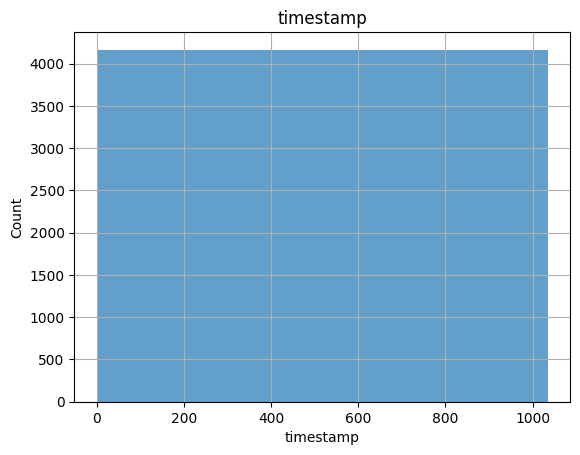

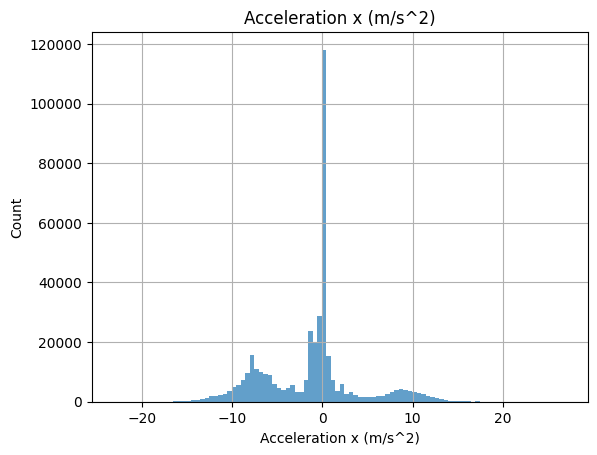

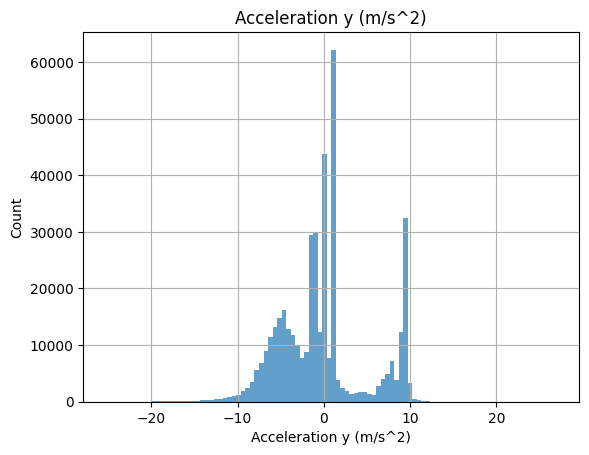

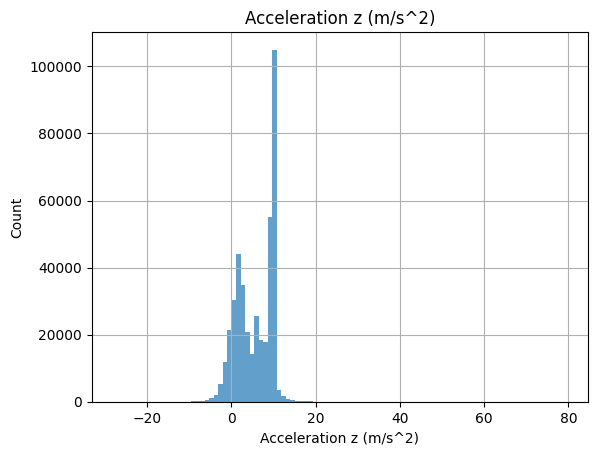

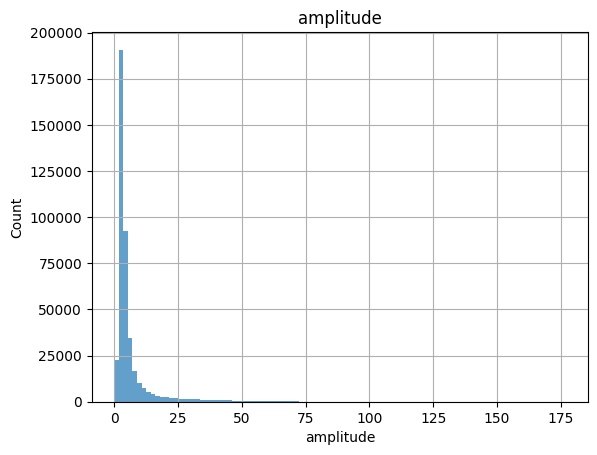

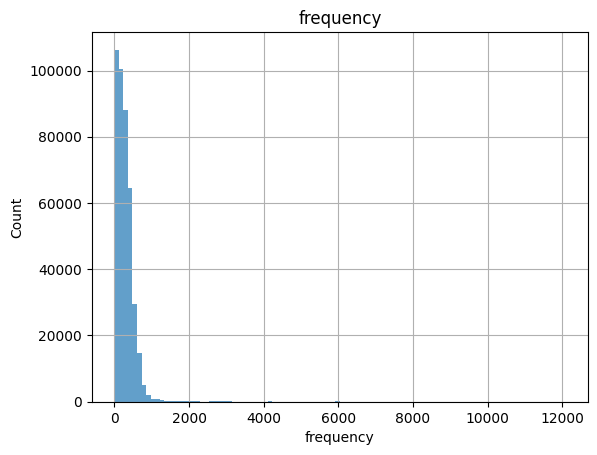

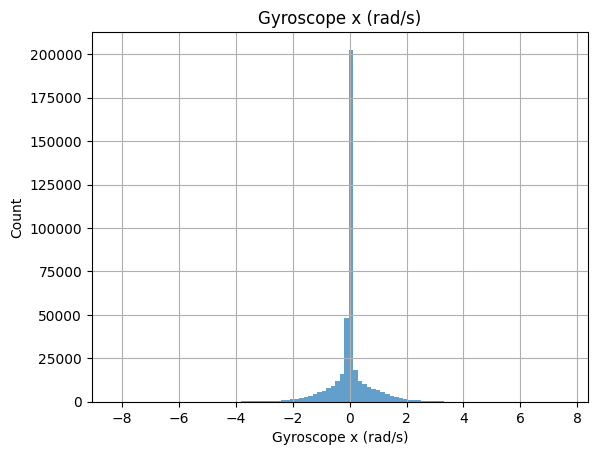

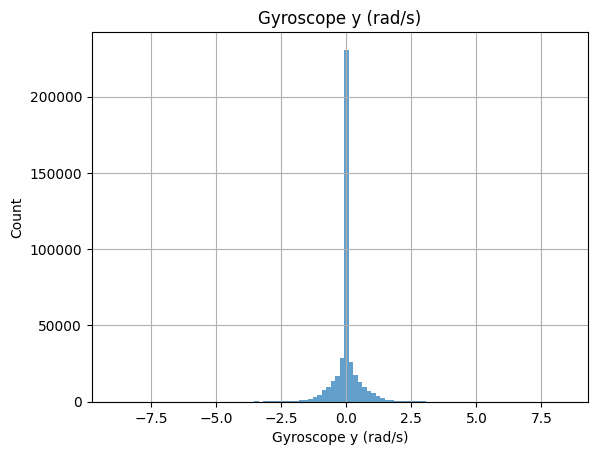

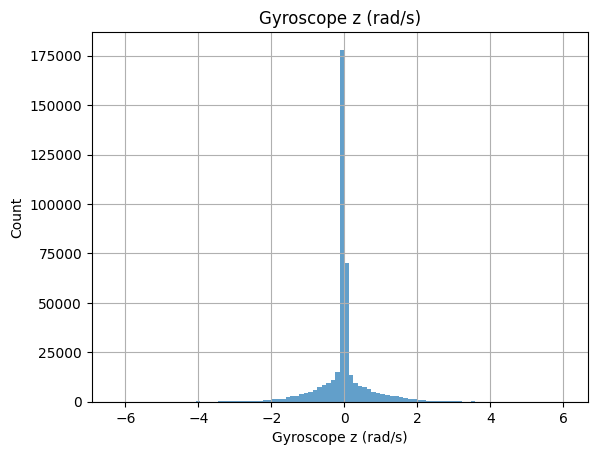

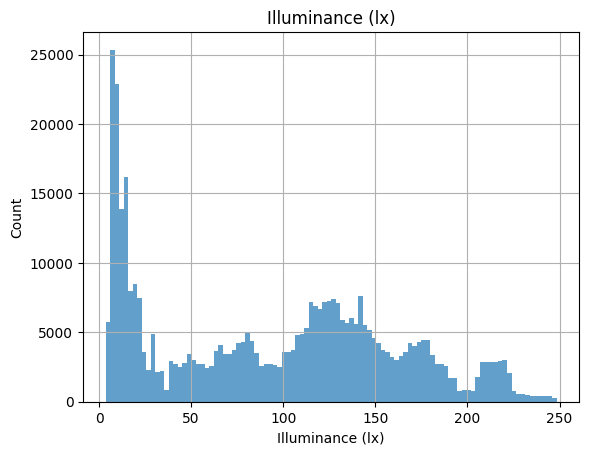

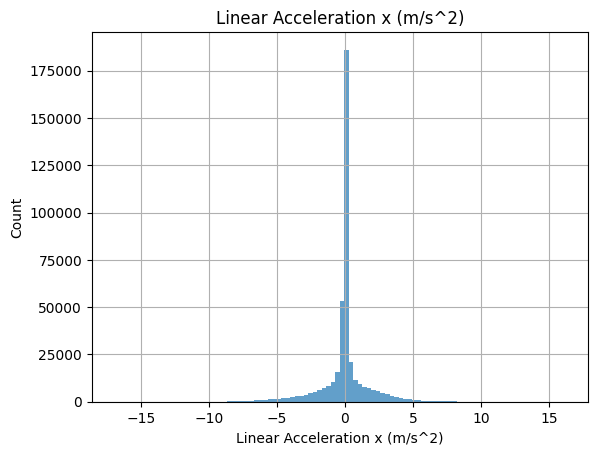

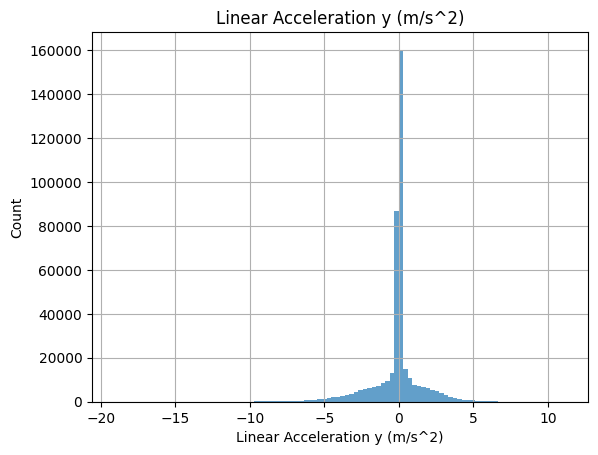

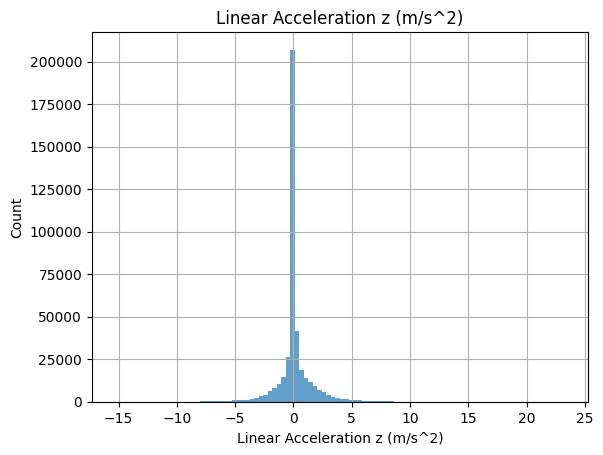

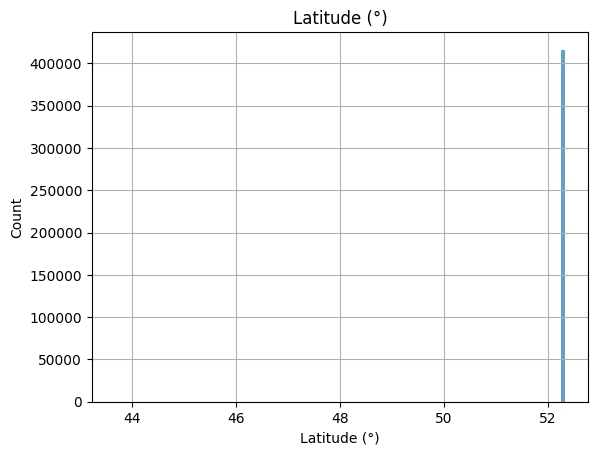

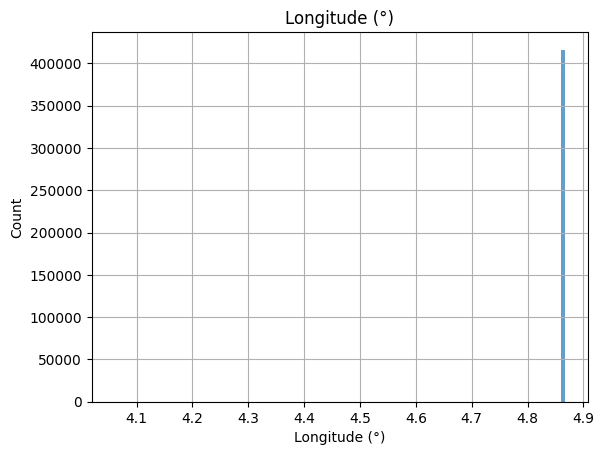

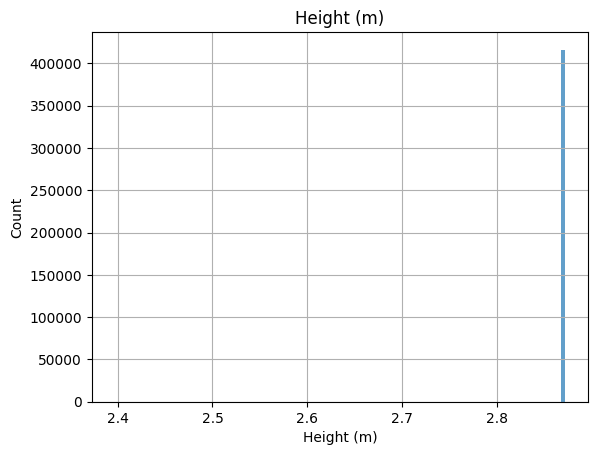

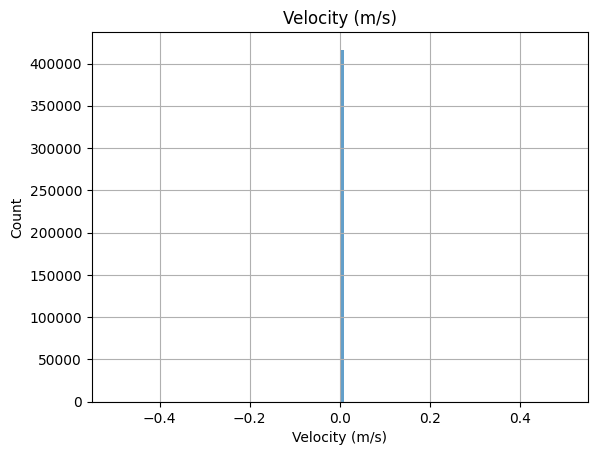

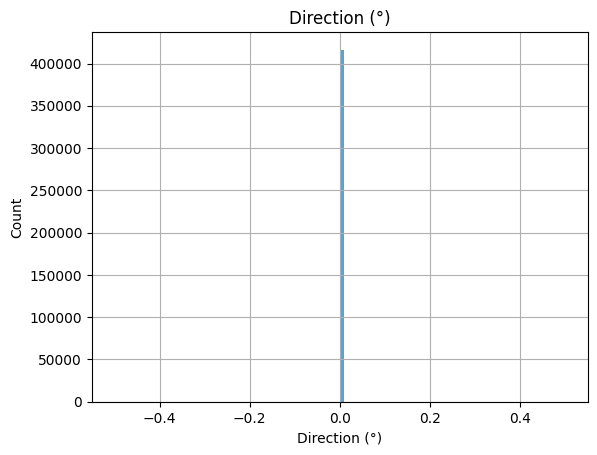

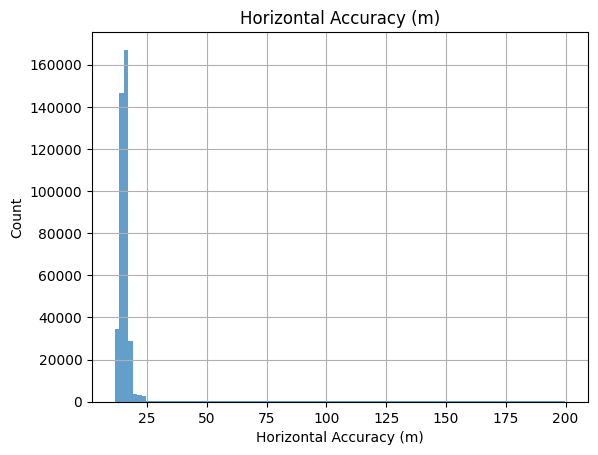

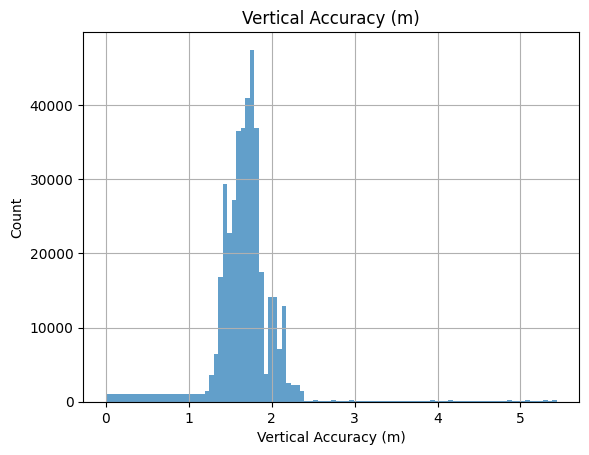

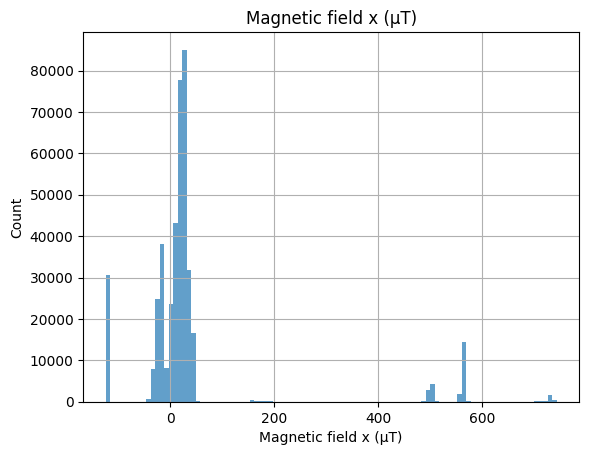

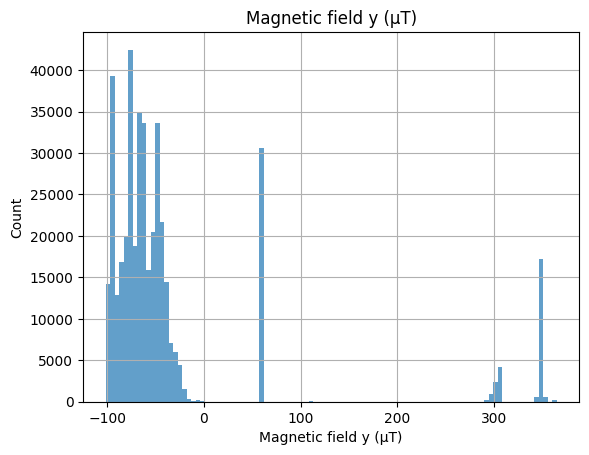

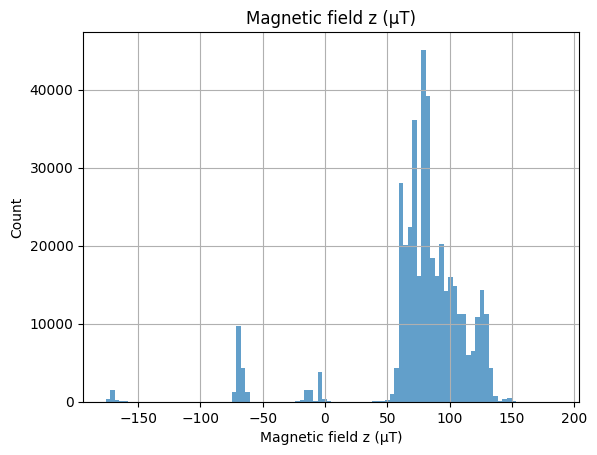

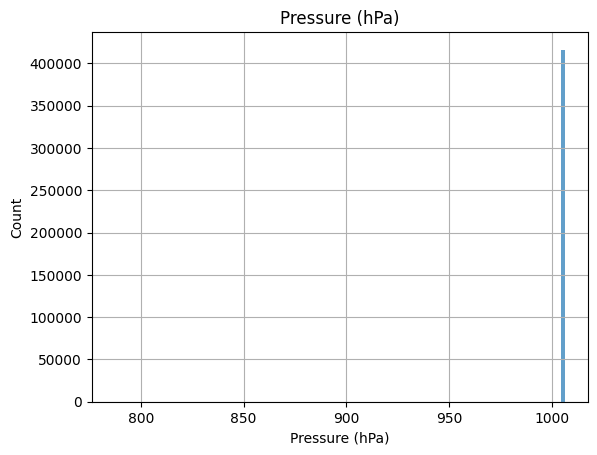

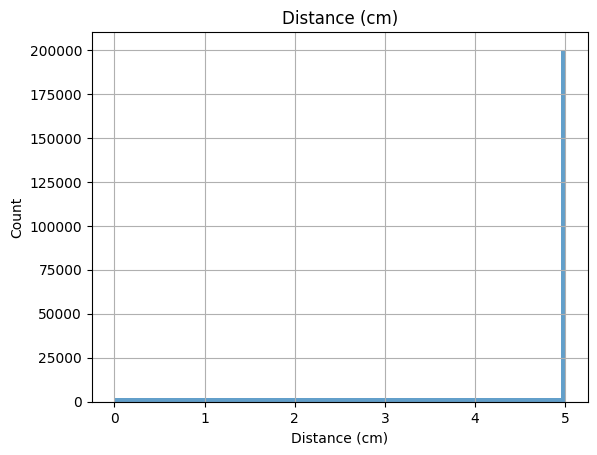

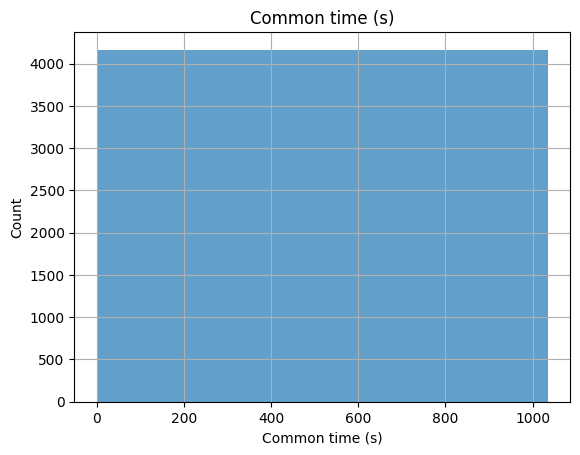

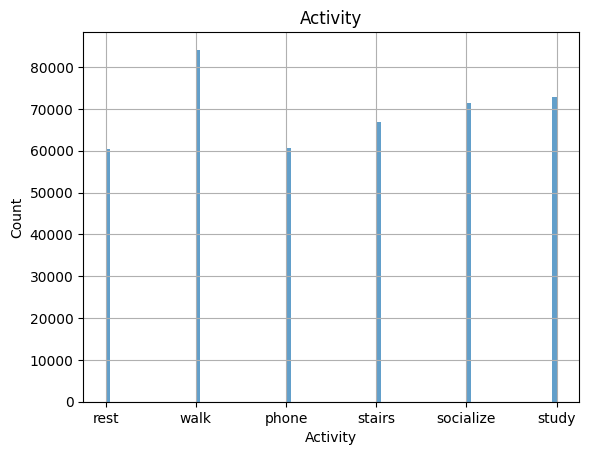

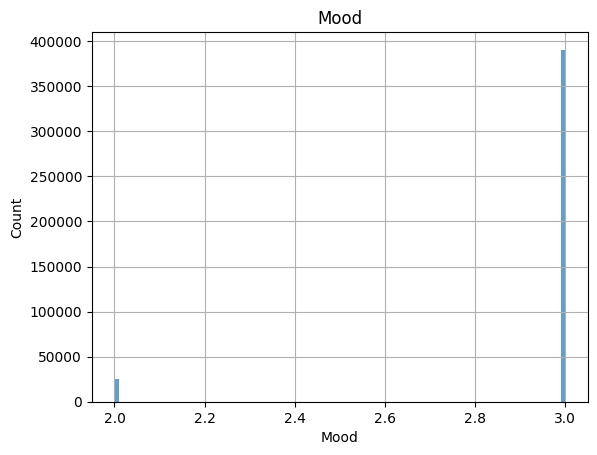

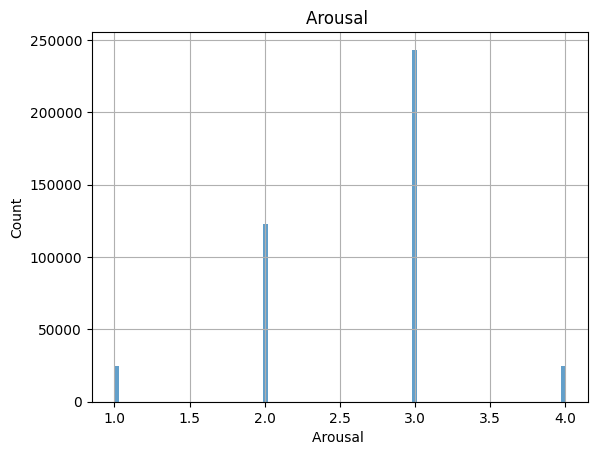

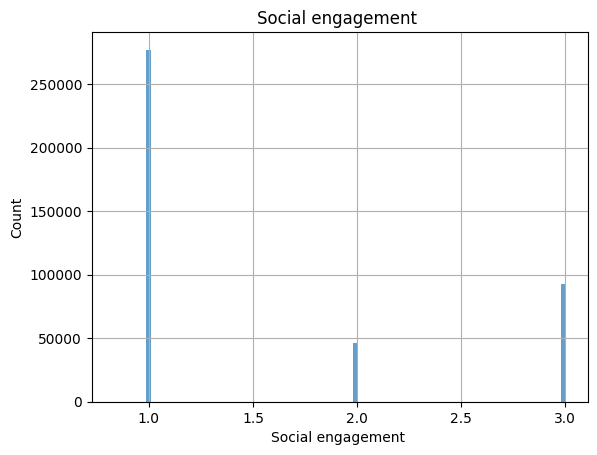

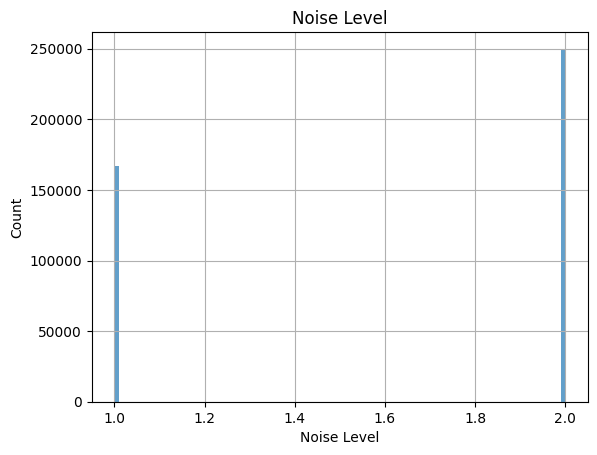

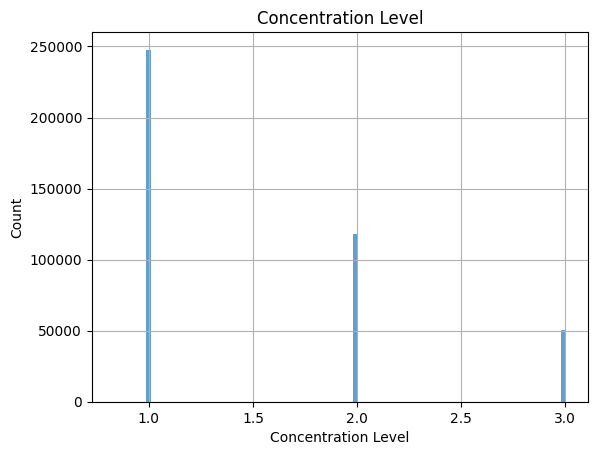

In [20]:

for col in df.columns:
    df[col].hist(bins=100, alpha=0.7)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

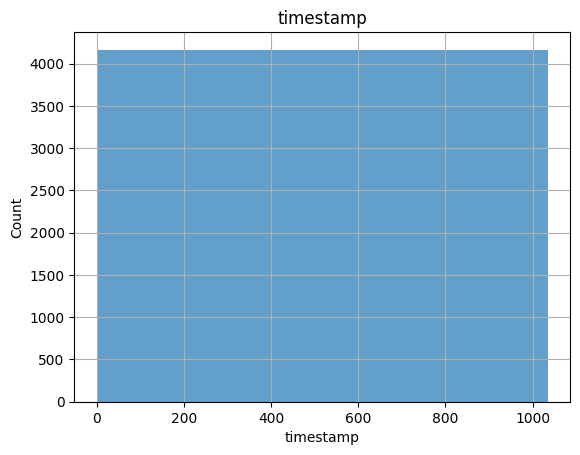

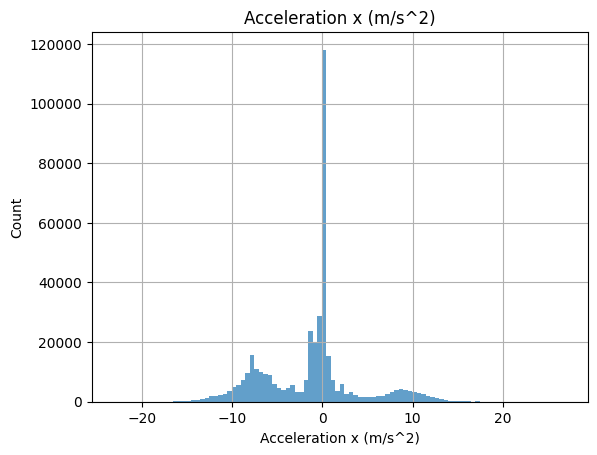

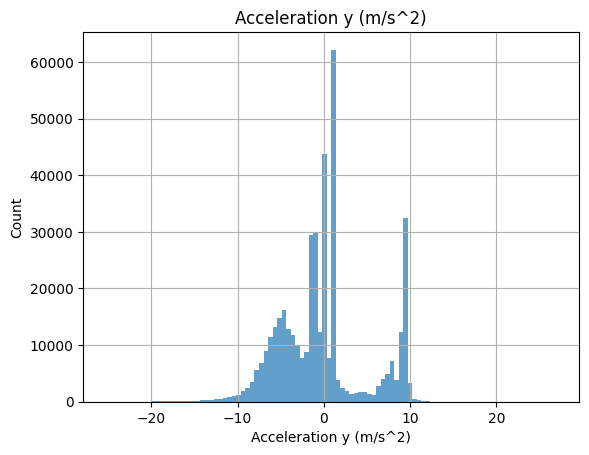

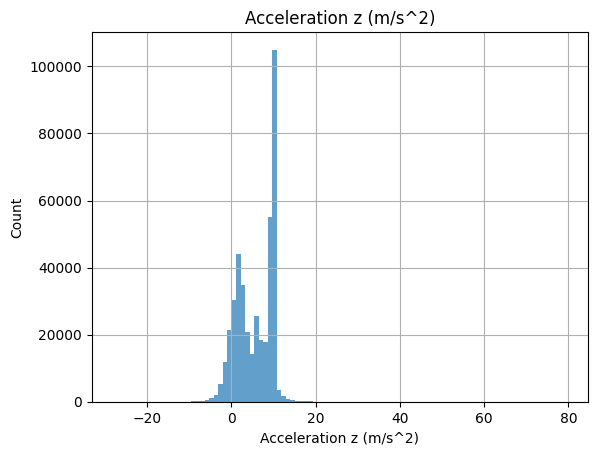

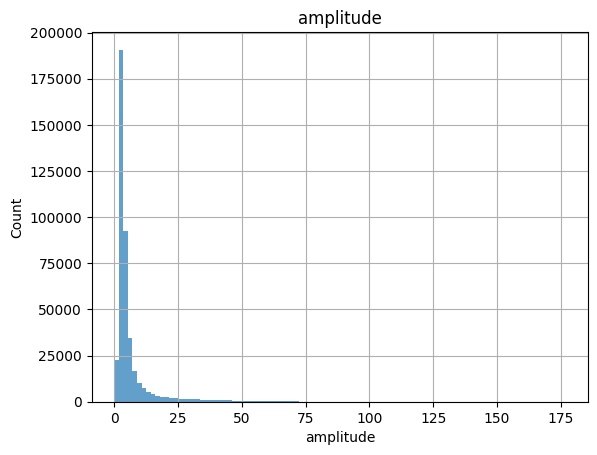

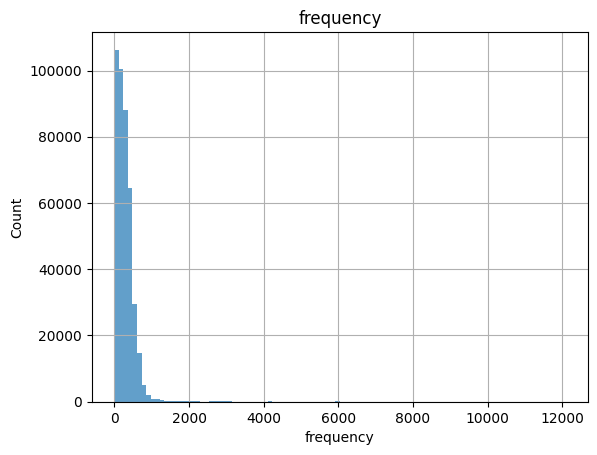

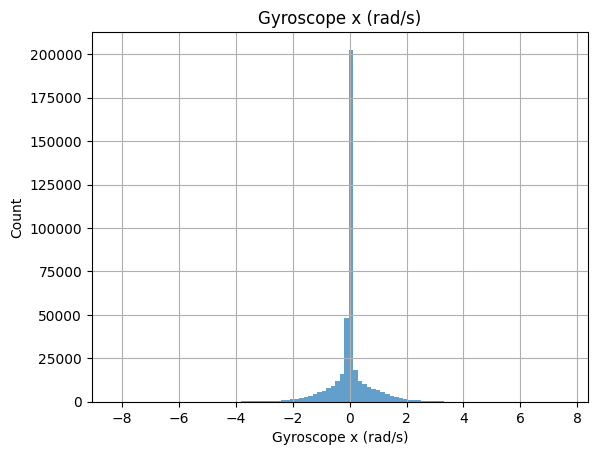

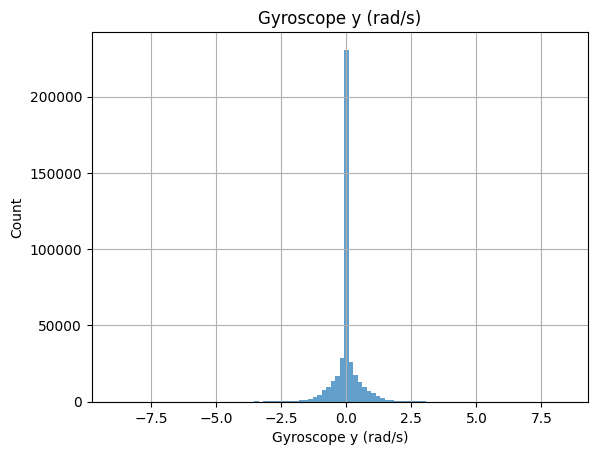

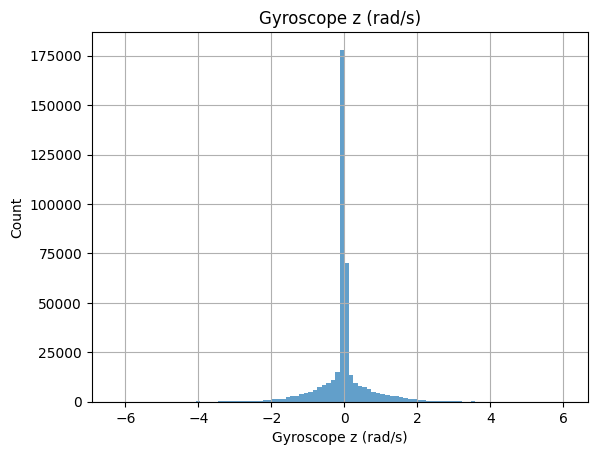

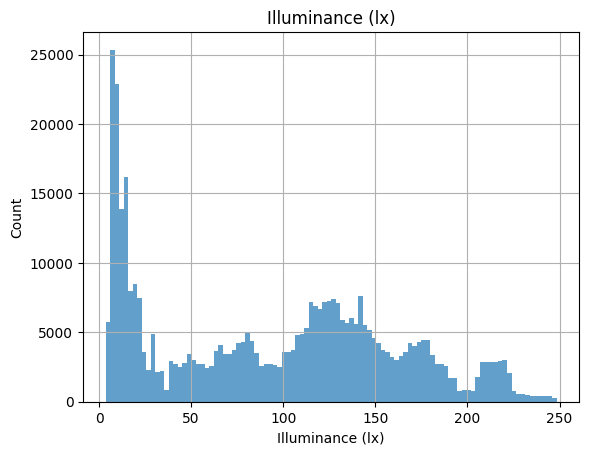

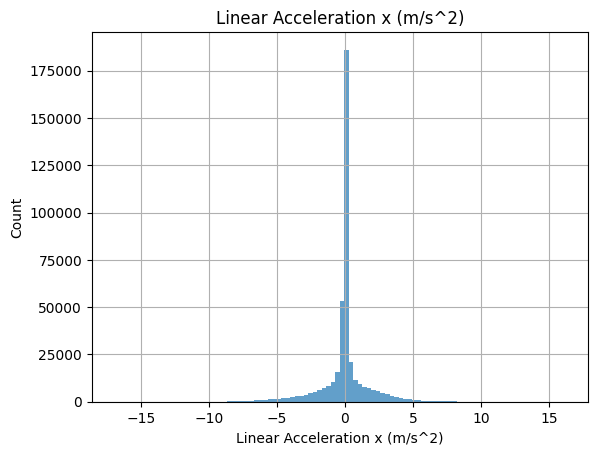

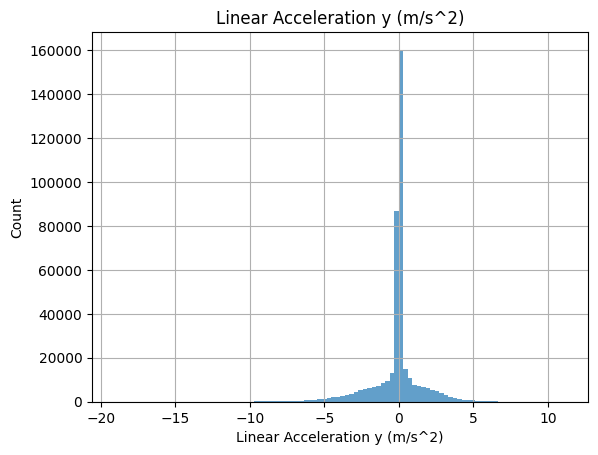

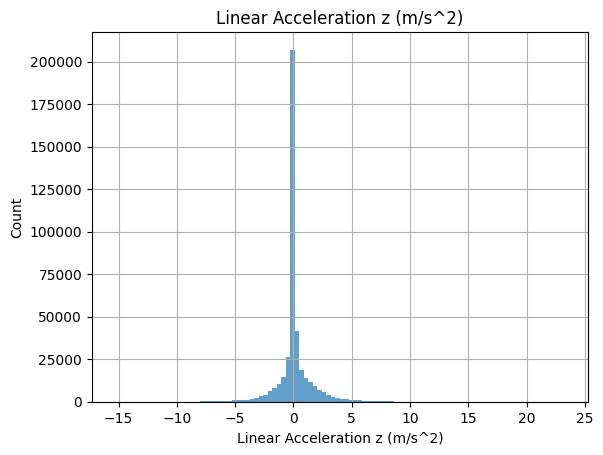

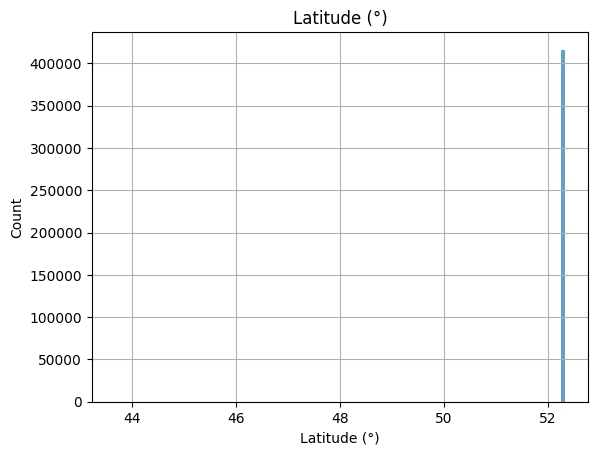

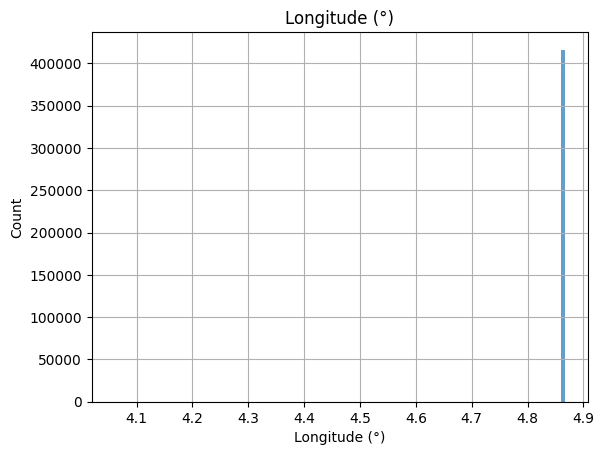

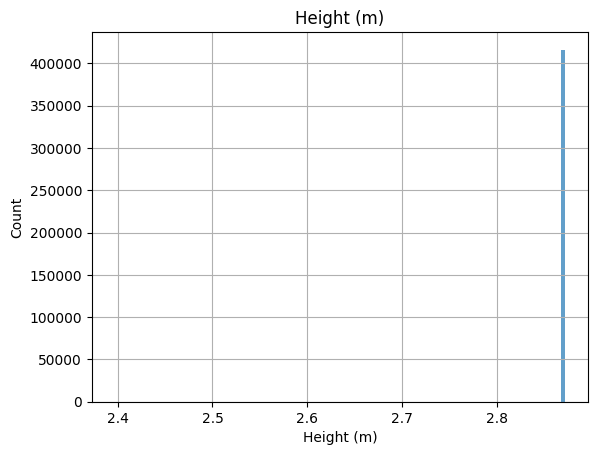

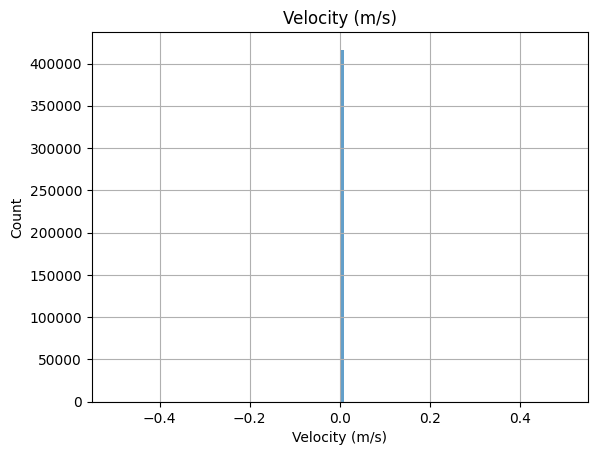

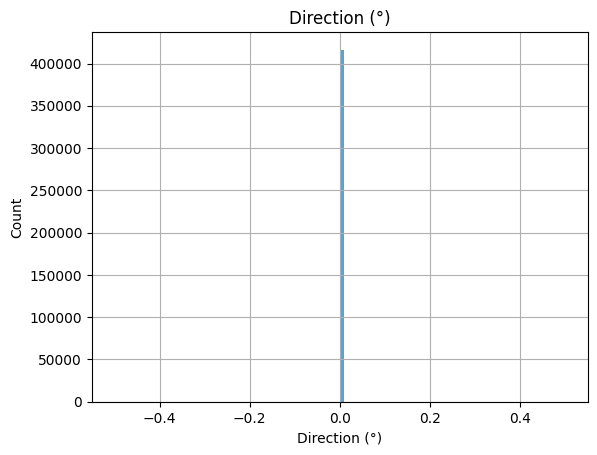

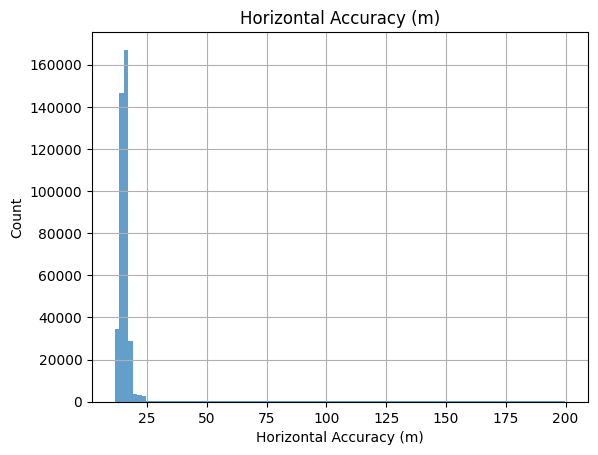

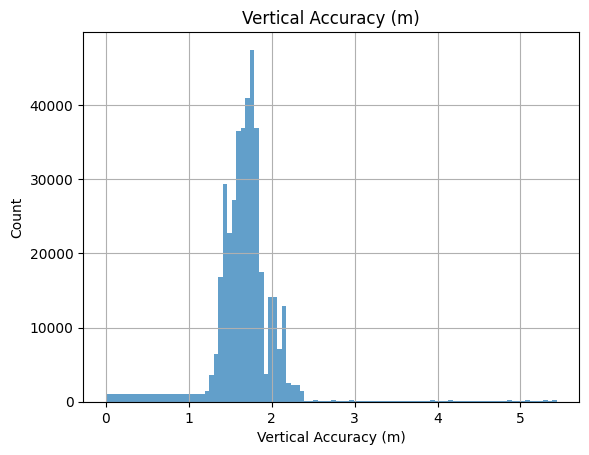

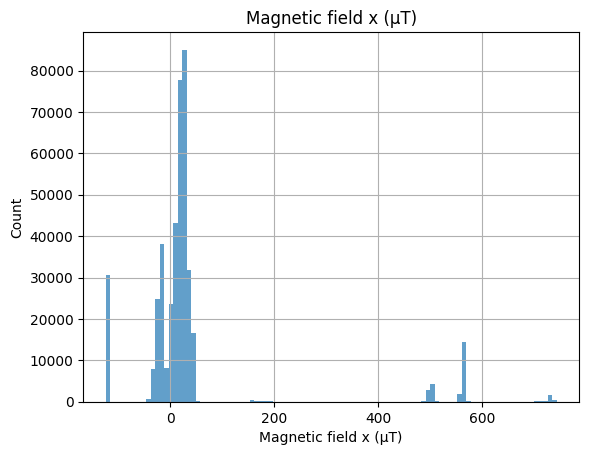

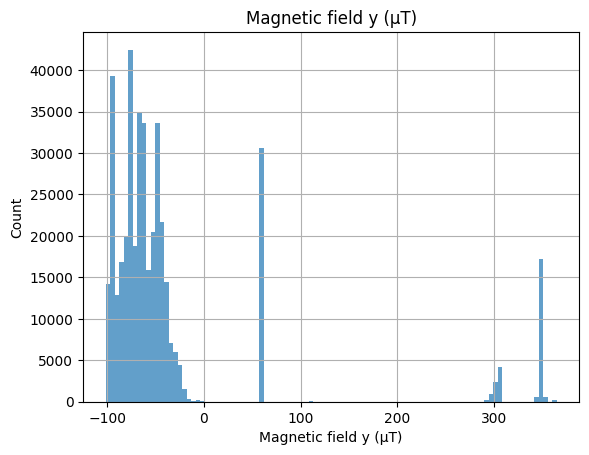

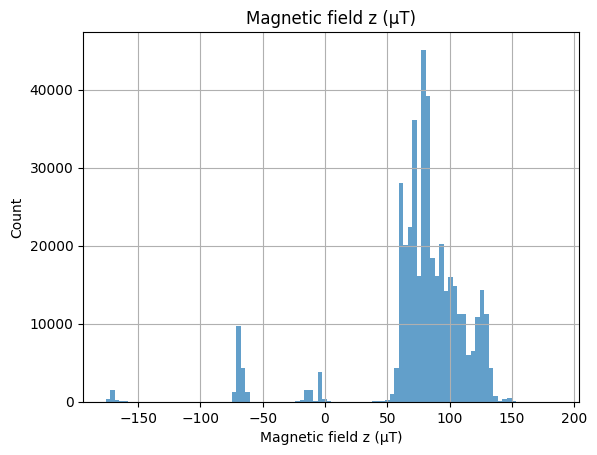

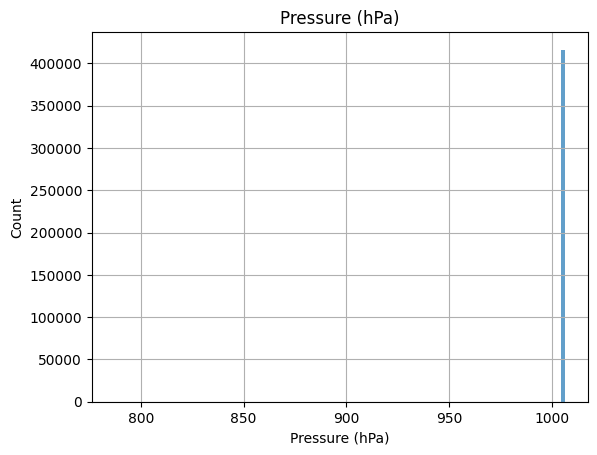

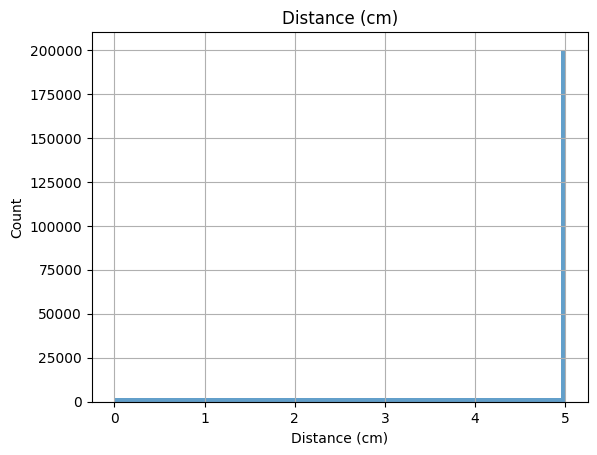

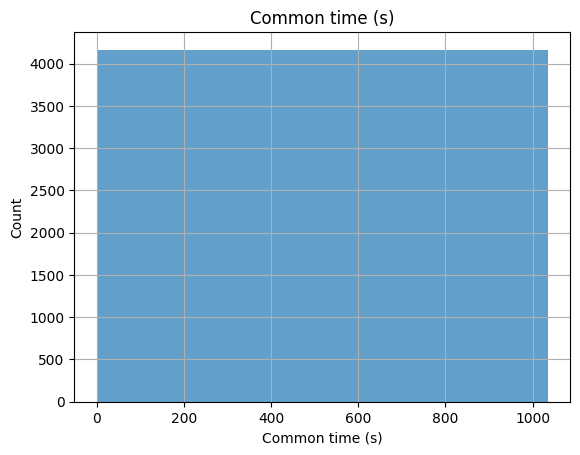

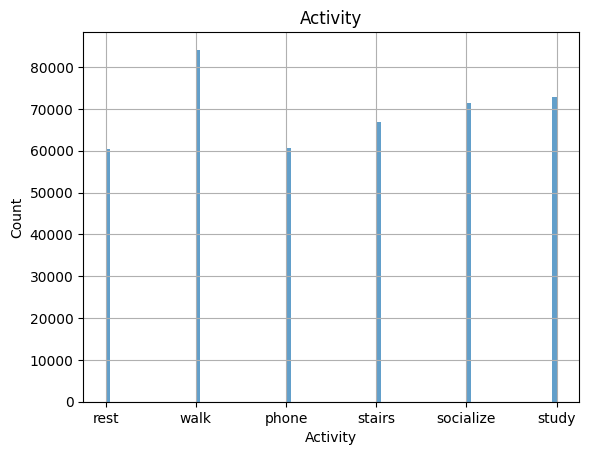

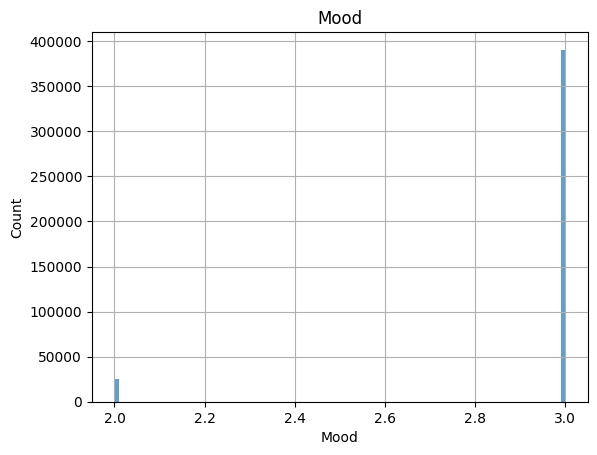

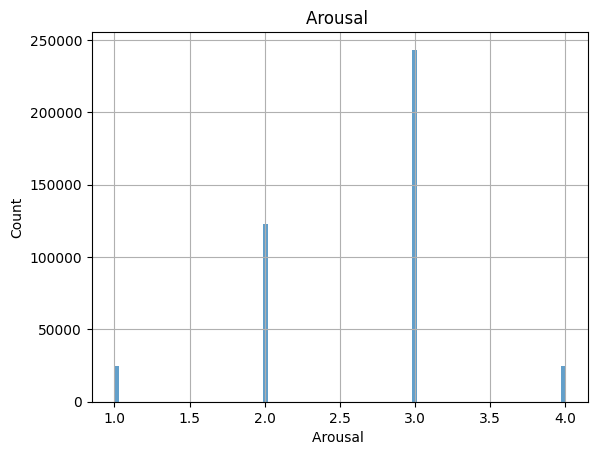

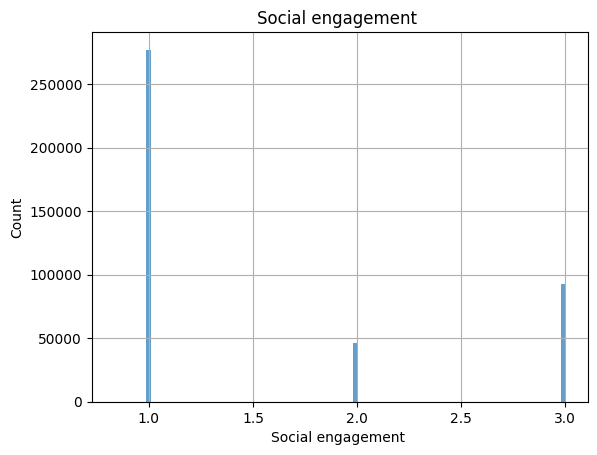

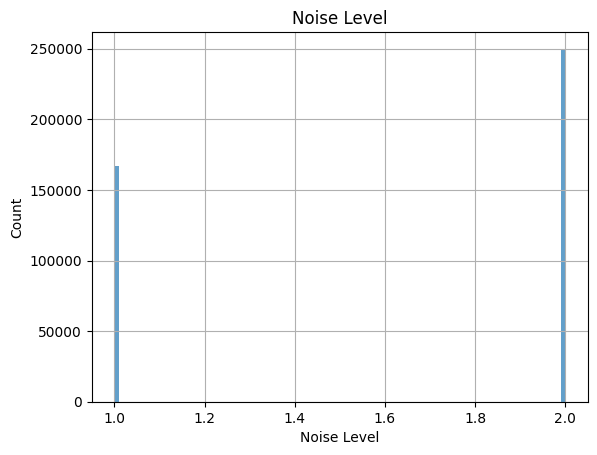

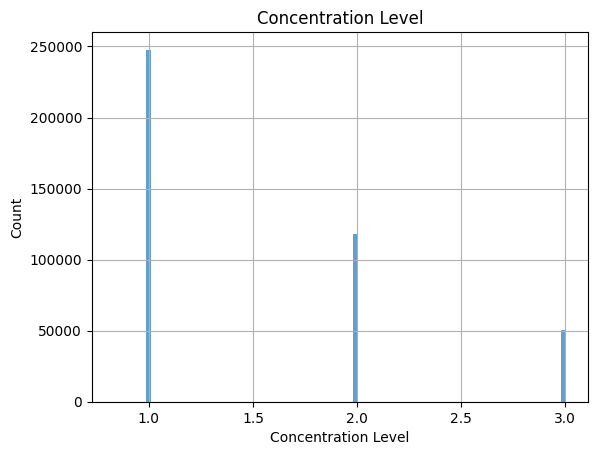

In [18]:

for col in df.columns:
    df[col].hist(bins=100, alpha=0.7)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()